In [24]:
## Install the package if needed:
#install.packages('Mcomp', repos='http://cran.us.r-project.org')

## Load the relevent packages
#library(ncdf4)  # For reading in the NCEP wind fields
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #
library(RColorBrewer)
library(compiler)  # required for JIT (below)
library(geosphere)

## Enable compilation (speed gain?)
enableJIT(3)

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x, origin="1899-12-30", tz=tz))
}

conv_roms_time = function(x, tz='UTC') {
    as.POSIXct(x, origin="1900-01-01")
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(9, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral', lim = c(-1e5, 1e5)) {
    x[x > lim[2]] = lim[2]
    x[x < lim[1]] = lim[1]
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

[1] 3

# Diurnal Signal Module

In [3]:
load(file='./RStates/ship.ncp.rdata')

In [11]:
##Filter based on distance from ship

distance.filter = function(data, d = 500) {
    l = rep(FALSE, nrow(data))
    
    for (i in 1:nrow(data)) {
        dis = distm(c(ship.data$LO[i], ship.data$LA[i]),
                    c(ship.data$Drifter.lon[i],
                      ship.data$Drifter.lat[i]), fun = distHaversine)
        
        ## If qualifies, then set l to TRUE
        if (dis < d) {
            l[i] = TRUE
        }
    }
    data[l,]
}

determine.dist = function() {
    n = c()
    d = seq(100, 5000, 100)
    
    for (i in d) {
        n = c(n, nrow(distance.filter(ship.data, i)))
    }
    plot(d, n)
}

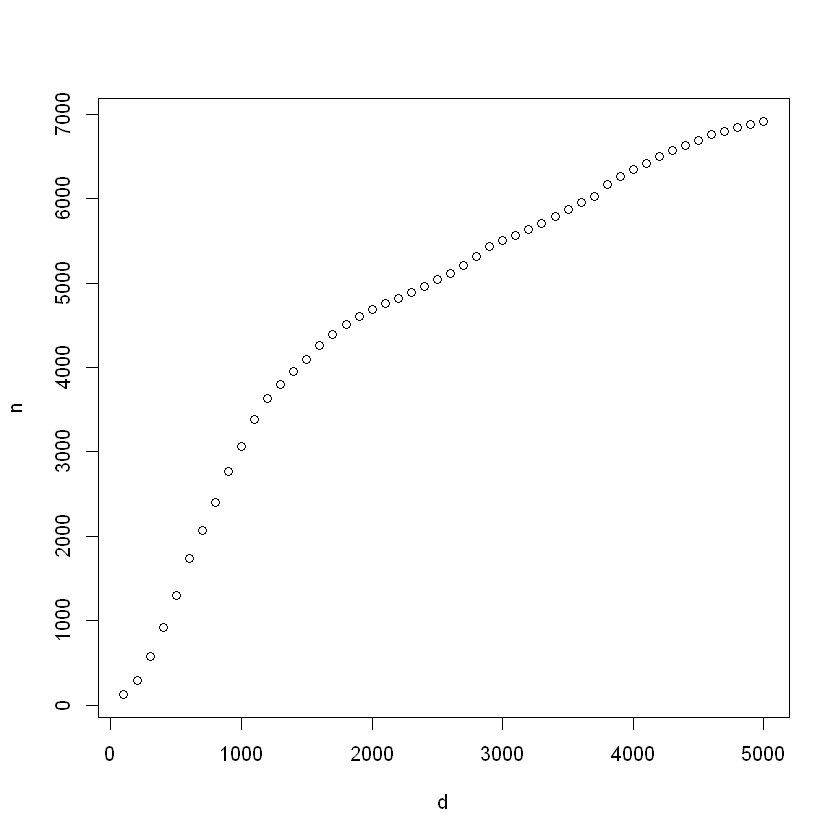

In [12]:
determine.dist()

In [13]:
ship.close = distance.filter(ship.data, 3000)

In [15]:
str(ship.close)

'data.frame':	5507 obs. of  47 variables:
 $ DT                 : POSIXct, format: "2017-06-09 07:12:06" "2017-06-09 07:14:07" ...
 $ TW                 : num  1.6 1.66 1.73 1.72 1.94 ...
 $ TI                 : num  82.8 80 77.4 78.7 77.5 ...
 $ TT                 : num  13.6 13.6 13.5 13.5 13.6 ...
 $ SA                 : num  33.6 33.6 33.6 33.6 33.6 ...
 $ OS                 : num  5.89 5.91 5.93 5.93 5.93 ...
 $ FL                 : num  5.51 5.45 5.21 5.27 5.13 ...
 $ AT                 : num  13.6 13.6 13.6 13.6 13.6 ...
 $ BP                 : num  1013 1013 1013 1013 1013 ...
 $ PA                 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ SA.1               : num  33.6 33.6 33.6 33.6 33.6 ...
 $ OX                 : num  6.52 6.52 6.28 6.41 6.26 ...
 $ OS.1               : num  5.89 5.91 5.93 5.93 5.93 ...
 $ FL.1               : num  5.51 5.45 5.21 5.27 5.13 ...
 $ BT                 : num  -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
 $ LA                 : num  35.1 35.1 35.1 35.1 3

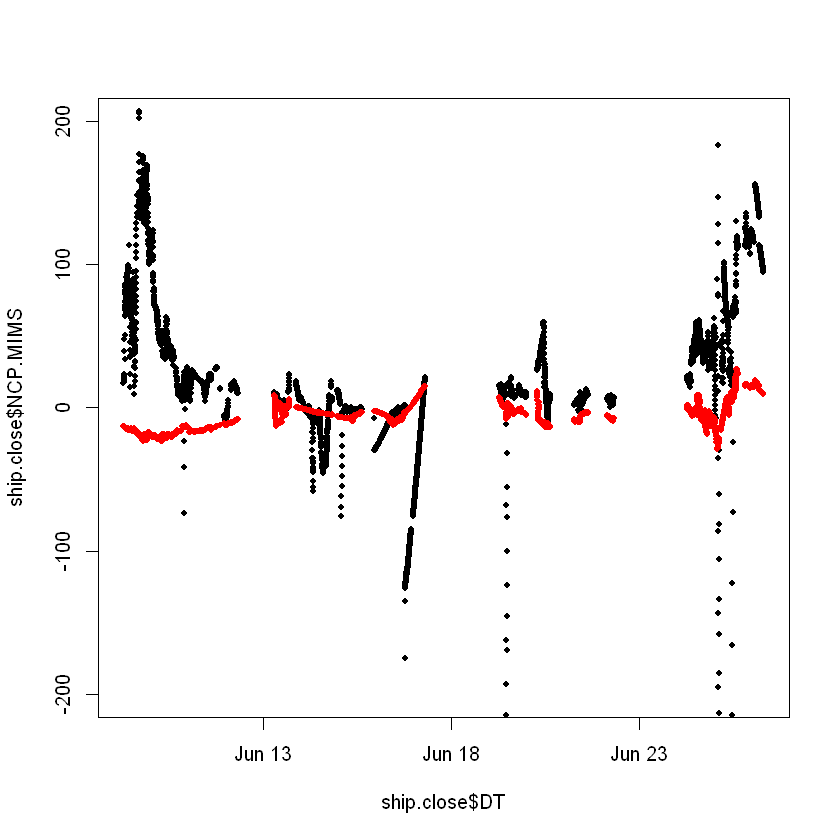

In [19]:
plot(ship.close$DT, ship.close$NCP.MIMS, pch=20, ylim=c(-200,200))
points(ship.close$DT, ship.close$NCP.EIMS, pch=20, ylim=c(-200,200), col='red')

In [42]:
plot.cycle = function(cycle, data) {
    l = which(data$Cycle == cycle)
    
    plot(ship.close$DT[l], ship.close$NCP.MIMS[l], pch=20, ylim=c(-100,100), main=cycle, ylab='NCP', xlab='')
    points(ship.close$DT[l], ship.close$NCP.EIMS[l], pch=20, ylim=c(-100,100), col='red')
    legend(min(ship.close$DT[l]), -50, c('MIMS', 'EIMS'), col=c('black', 'red'), lwd=4, cex=0.7)
    
    cols = make.div.pal(ship.close$NCP.MIMS, n = 100, lim = c(-200,200))
    plot(ship.close$LO[l], ship.close$LA[l], pch=16, cex=1.2, ylab='Latitude', xlab='Longitude', col=cols)
}

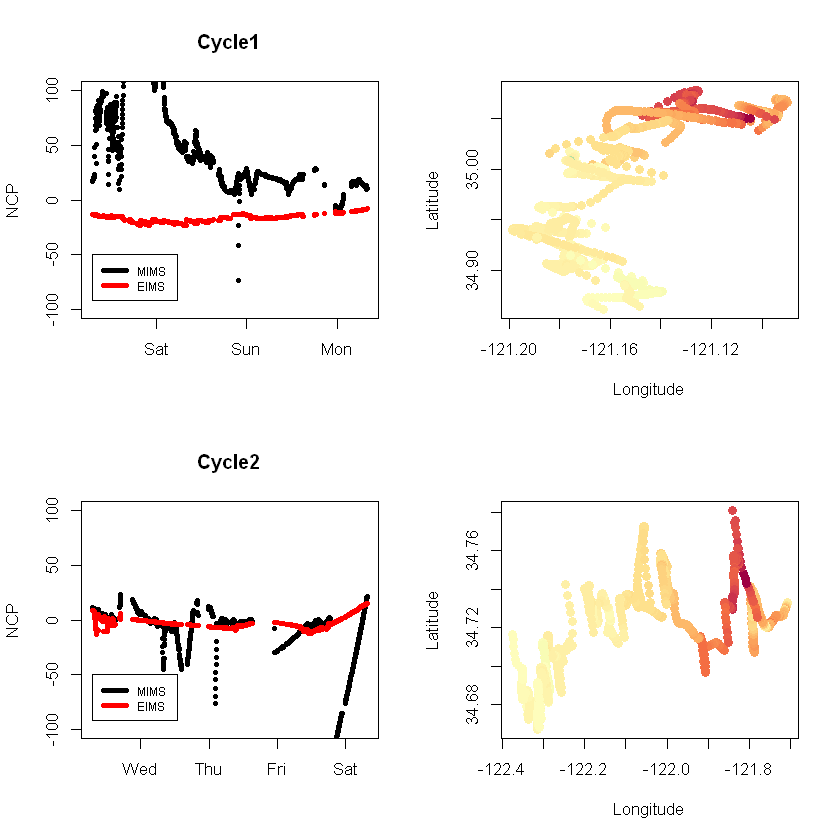

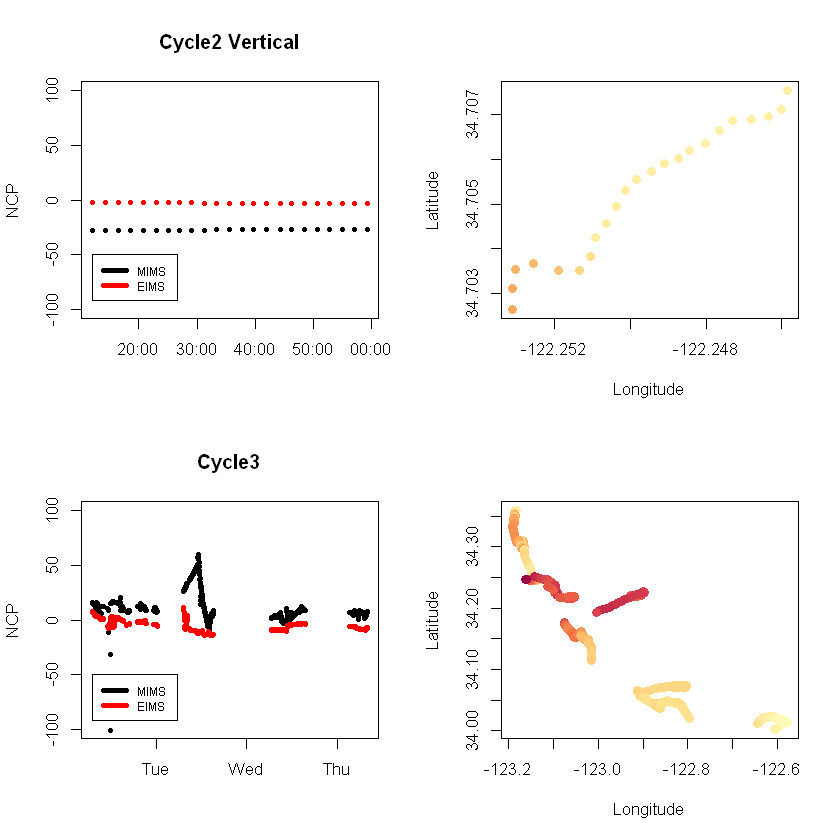

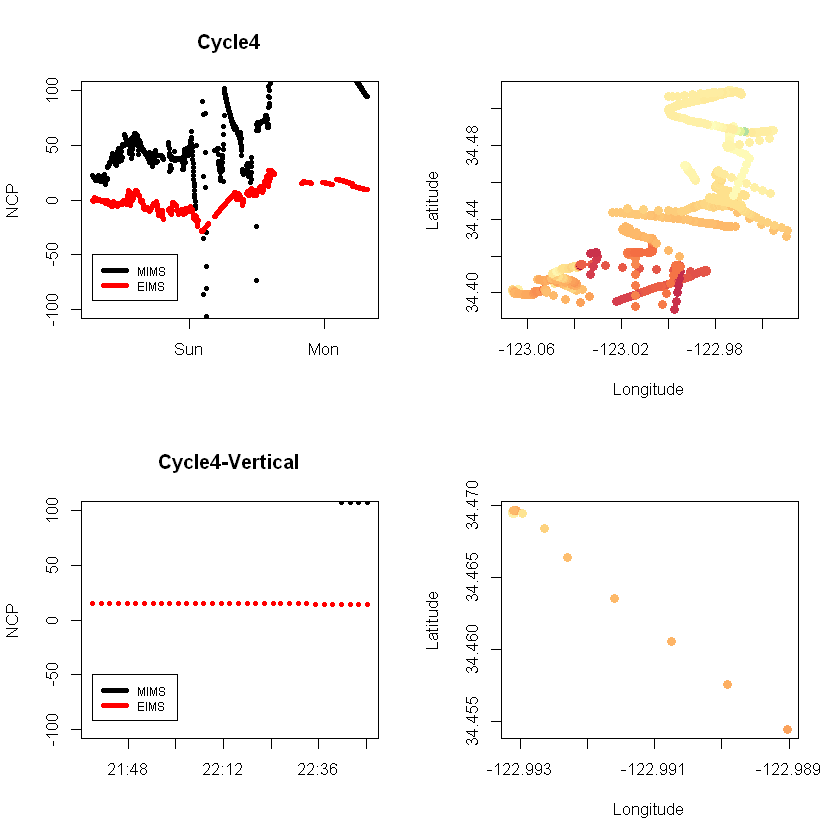

In [43]:
par(mfrow=c(2,2))
for (i in unique(ship.close$Cycle)) {
    plot.cycle(i, ship.close)
}